In [1]:
from __future__ import print_function, division

import os, json, sys
sys.path.append('../..') 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image


from IPython.display import Image

In [2]:
plt.ion()   # interactive mode
folder_data = '/media/tiago/tiagobotari/data'

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
_image_size = 32
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(_image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(.3, .3, .3),
        transforms.ToTensor(),
        transforms.Normalize(_mean, _std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(_image_size),
        transforms.ToTensor(),
        transforms.Normalize(_mean, _std)
    ]),
}

In [4]:
ants = False
if ants:
    data_dir = '{:}/hymenoptera_data'.format(folder_data)
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device

    data_loader = dataloaders['train']

In [5]:
batch_size = 144
data_dir = '{:}/dogscats'.format(folder_data)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

data_loader = dataloaders['train']

### Visualize

In [470]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    if inp.is_cuda:
        inp = inp.cpu().detach()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updateda

In [7]:
# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)
# print([class_names[x] for x in classes])
# imshow(out )

In [8]:
# # Load MNIST Data
# dataset = datasets.MNIST(root=folder_data, train=True, transform=transforms.ToTensor(), download=False)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

In [9]:
# Fixed input for debugging
fixed_x, _ = next(iter(data_loader))
fixed_x = fixed_x.to(device)
print(fixed_x.size())
save_image(fixed_x, '../image.png')

# Image('real_image.png')

torch.Size([144, 3, 32, 32])


# VAE CNN

In [10]:
def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)
def flatten(x):
    return to_var(x.view(x.size(0), -1))
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# from density_lime.densities.density_cvae import VAE

class VAE(nn.Module):
    def __init__(self, image_channels=3, kernel_size=3, stride=1, latent_dim=32):
        super().__init__()
        self.verbose = True
#         self.nodes_dim = nodes_dim
        self.latent_dim = latent_dim
        self.chanels = [32, 64, 128, 256, 512]
        # Encoder
        self.layers_encoder = nn.ModuleList(self.create_layers_encoder(image_channels=image_channels)) 
        
        # Mu and log_var
        in_linear_layer = self.chanels[-1] # *4
        self.fc_mu = nn.Linear(in_linear_layer, self.latent_dim)
        self.fc_log_var = nn.Linear(in_linear_layer, self.latent_dim)
        
        self.fc_out = nn.Linear(self.latent_dim, in_linear_layer)
        
        # Decoder
        self.layers_decoder = nn.ModuleList(
            self.create_layers_decoder(
                image_channels=image_channels
            )
        )
    
    def encode(self, x):
        x_in = x
#         print('encode out size: ', x_in.size())
        for layer in self.layers_encoder:
            # TODO: doubt!! no functional here, not sure what is the best option
            x_in = layer(x_in)
#           
#             print('##############################')
#             print(layer)
#             print('encode out size: ', x_in.size())
        return x_in

    def decode(self, z):
        x_in = z
#         print('decode out size: ', x_in.size())
        for layer in self.layers_decoder:
            # TODO: doubt!! no functional here, not sure what is the best option
            x_in = layer(x_in)
#             print('##############################')
#             print(layer)
#             print('decode out size: ', x_in.size())
#         print('>>>>>>>>>>decode out size: ', x_in.size())
        return x_in
            
    @staticmethod
    def reparameterize(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps*std    
    
    def forward(self, x):
        x_enconde = self.encode(x)
        x_enconde = torch.flatten(x_enconde, start_dim=1)
#         x_enconde = x_enconde.view(-1, self.nodes_dim)
#         print(x_enconde.size())
        mu, log_var = self.fc_mu(x_enconde), self.fc_log_var(x_enconde)
        z = self.reparameterize(mu, log_var)
        z = self.fc_out(z)
        z = z.view(-1, 512, 1, 1)
        x_out = self.decode(z)
#         print('------------------------------------------------------------')
        return x_out, mu, log_var
    
    def create_layers_encoder(self, image_channels):
        # TODO: Would be nice to have some options here.
        # TODO: doubt!!! I choose to use the Elu layer here. not sure about this.
        # TODO: I am thinking to put a batch normalization between the layers.
        out_chanels = self.chanels
        layers = list()
        for out_chanel in out_chanels:
            layers.append(
                nn.Sequential(
                nn.Conv2d(image_channels, out_chanel, kernel_size=3, stride=2, padding=1)
                , nn.BatchNorm2d(out_chanel)
                , nn.LeakyReLU()   
                )
            )
            image_channels = out_chanel
        return layers
    
    def create_layers_decoder(self, image_channels):
        # TODO: Would be nice to have some options here.
        # TODO: doubt!!! I choose to use the Elu layer here. not sure about this.
        # TODO: I am thinking to put a batch normalization between the layers.
        out_chanels = self.chanels
        out_chanels.reverse()
#         print(out_chanels)
#         print(out_chanels[:-1])
        layers = list()
        for in_chanel, out_chanel in zip(out_chanels[:-1], out_chanels[1:]) :
            layers.append(
                nn.Sequential(
                 nn.ConvTranspose2d(
                     in_chanel, out_chanel, kernel_size=3, stride=2, padding=1, output_padding=1
#                  , bias=False  # TODO: I want to include this!
                 )
                , nn.BatchNorm2d(out_chanel)
                , nn.LeakyReLU()   
                )
            )
                
        layers.append(
            nn.Sequential(
                            nn.ConvTranspose2d(out_chanels[-1],
                                               out_chanels[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
#                             nn.BatchNorm2d(out_chanels[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(out_chanels[-1], out_channels=3,
                                      kernel_size=3, padding=1),
                            nn.Sigmoid()
            )
        )
        return layers
    
    def loss_function(self, recons, input_, mu, log_var, kld_weight=1):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons_loss = F.mse_loss(recons, input_)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return loss  #{'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}
    
    def loss_function_2(self, recon_x, x, mu, log_var):
        # TODO: check if this is the best loss
        bce = functional.binary_cross_entropy(recon_x, x.view(-1, self.input_dim), reduction='sum')
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return bce + kld

In [12]:
torch.cuda.empty_cache()
image_channels = 3
vae = VAE(image_channels=image_channels, latent_dim=256*2)
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (layers_encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

In [14]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [15]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [24]:
def train_model(epochs=100, loss_list=None):
    if loss_list is None: loss_list = []
    for epoch in range(epochs):
        scheduler.step()
        for idx, (images, _) in enumerate(data_loader):
            images = images.to(device)
            recon_images, mu, logvar = vae(images)
#             loss = vae.loss_function(recon_images, images, mu, logvar)
            loss = loss_fn(recon_images, images, mu, logvar)
            loss_list.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#        if idx%100 == 0:
        print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/batch_size))

        recon_x, _, _ = vae(fixed_x)
#        print(recon_x.size(0))
        save_image(recon_x.view(recon_x.size(0), image_channels, _image_size, _image_size).data.cpu(), f'{folder_data}/reco/i_{epoch}_{idx}.png')
        save_image(recon_x.view(recon_x.size(0), image_channels, _image_size, _image_size).data.cpu(), f'{folder_data}/reco/aai.png')
    return loss_list

In [25]:
loss_list = train_model(epochs=500)

Epoch[1/500] Loss: -41424.017
Epoch[2/500] Loss: -36032.309
Epoch[3/500] Loss: -34032.132
Epoch[4/500] Loss: -44350.965
Epoch[5/500] Loss: -34175.288
Epoch[6/500] Loss: -37677.354
Epoch[7/500] Loss: -43592.517
Epoch[8/500] Loss: -35193.163
Epoch[9/500] Loss: -38156.642
Epoch[10/500] Loss: -38309.288
Epoch[11/500] Loss: -36993.302
Epoch[12/500] Loss: -42888.038
Epoch[13/500] Loss: -38734.427
Epoch[14/500] Loss: -34711.941
Epoch[15/500] Loss: -34723.368
Epoch[16/500] Loss: -34176.458
Epoch[17/500] Loss: -43735.615
Epoch[18/500] Loss: -31152.347
Epoch[19/500] Loss: -37695.674
Epoch[20/500] Loss: -37133.552
Epoch[21/500] Loss: -34992.795
Epoch[22/500] Loss: -37358.500
Epoch[23/500] Loss: -34143.403
Epoch[24/500] Loss: -43161.733
Epoch[25/500] Loss: -38479.997
Epoch[26/500] Loss: -36110.003
Epoch[27/500] Loss: -40762.097
Epoch[28/500] Loss: -39824.278
Epoch[29/500] Loss: -36559.750
Epoch[30/500] Loss: -36255.969
Epoch[31/500] Loss: -37138.094
Epoch[32/500] Loss: -38799.021
Epoch[33/500] Los

Epoch[261/500] Loss: -40655.667
Epoch[262/500] Loss: -42736.194
Epoch[263/500] Loss: -38558.250
Epoch[264/500] Loss: -40375.375
Epoch[265/500] Loss: -37436.847
Epoch[266/500] Loss: -39528.062
Epoch[267/500] Loss: -37516.403
Epoch[268/500] Loss: -36662.764
Epoch[269/500] Loss: -35380.993
Epoch[270/500] Loss: -41204.073
Epoch[271/500] Loss: -38658.156
Epoch[272/500] Loss: -35534.417
Epoch[273/500] Loss: -37971.316
Epoch[274/500] Loss: -37973.500
Epoch[275/500] Loss: -41688.524
Epoch[276/500] Loss: -37680.583
Epoch[277/500] Loss: -39916.573
Epoch[278/500] Loss: -40175.712
Epoch[279/500] Loss: -37909.660
Epoch[280/500] Loss: -41622.406
Epoch[281/500] Loss: -40671.045
Epoch[282/500] Loss: -35624.052
Epoch[283/500] Loss: -43422.517
Epoch[284/500] Loss: -39656.458
Epoch[285/500] Loss: -43799.365
Epoch[286/500] Loss: -41726.705
Epoch[287/500] Loss: -34544.035
Epoch[288/500] Loss: -39102.764
Epoch[289/500] Loss: -35658.149
Epoch[290/500] Loss: -38606.642
Epoch[291/500] Loss: -36373.910
Epoch[29

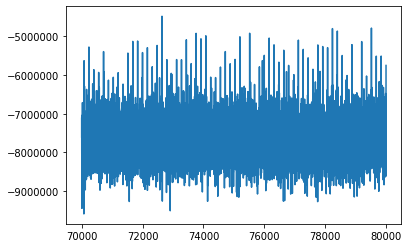

In [27]:
x = list(range(len(loss_list)))
plt.plot(x[70000:], loss_list[70000:])

In [18]:
train_model(epochs=100)

Epoch[1/100] Loss: -52096.399
Epoch[1/100] Loss: -52094.816
Epoch[2/100] Loss: -50851.958
Epoch[2/100] Loss: -50142.514
Epoch[3/100] Loss: -58690.271
Epoch[3/100] Loss: -55759.917
Epoch[4/100] Loss: -51237.035
Epoch[4/100] Loss: -51080.906
Epoch[5/100] Loss: -55236.681
Epoch[5/100] Loss: -49620.722
Epoch[6/100] Loss: -46695.878
Epoch[6/100] Loss: -45371.441
Epoch[7/100] Loss: -52875.559
Epoch[7/100] Loss: -52818.677
Epoch[8/100] Loss: -52886.931
Epoch[8/100] Loss: -53138.163
Epoch[9/100] Loss: -52718.587
Epoch[9/100] Loss: -47872.118
Epoch[10/100] Loss: -52311.649
Epoch[10/100] Loss: -52288.240
Epoch[11/100] Loss: -54970.306
Epoch[11/100] Loss: -52780.378
Epoch[12/100] Loss: -55119.444
Epoch[12/100] Loss: -50601.024
Epoch[13/100] Loss: -51154.594
Epoch[13/100] Loss: -50891.017
Epoch[14/100] Loss: -46351.559
Epoch[14/100] Loss: -48444.691
Epoch[15/100] Loss: -55665.559
Epoch[15/100] Loss: -55005.719
Epoch[16/100] Loss: -51895.868
Epoch[16/100] Loss: -49774.156
Epoch[17/100] Loss: -54707

KeyboardInterrupt: 

In [ ]:
path_model_cvae = '../models/mode_cvae.pth'
torch.save(vae, path_model_cvae)

In [ ]:
# model = torch.load(path_model_cvae)
# model.eval()

100


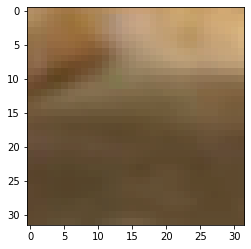

101


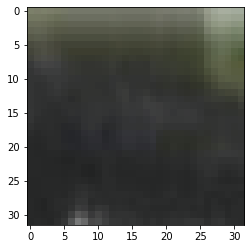

102


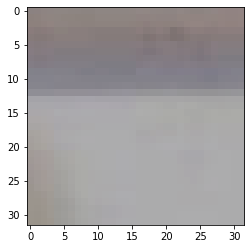

103


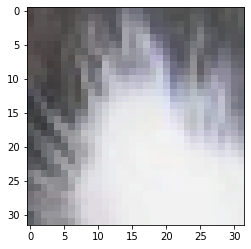

104


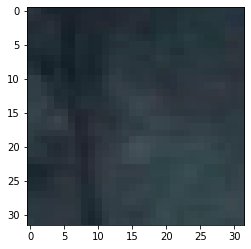

105


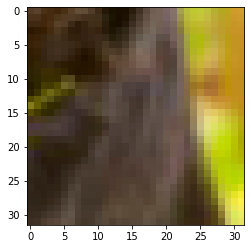

106


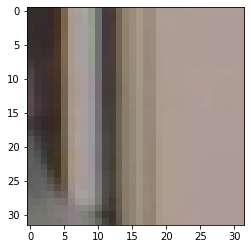

107


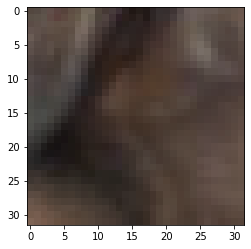

108


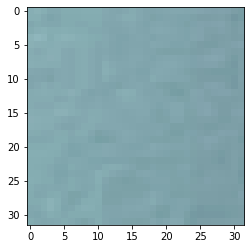

109


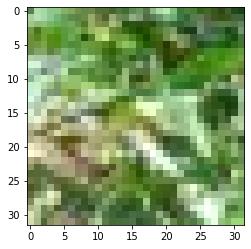

110


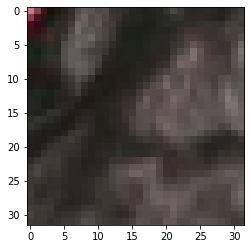

111


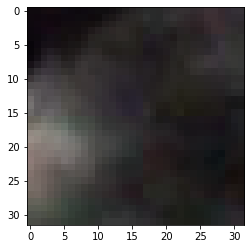

112


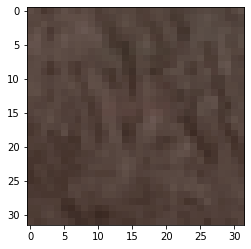

113


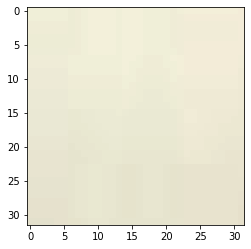

114


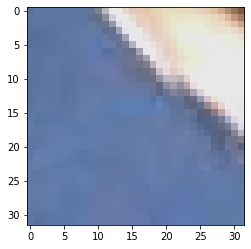

115


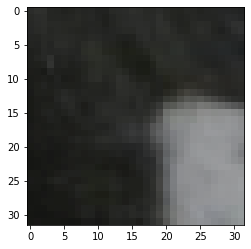

116


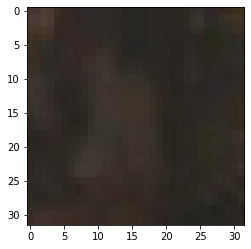

117


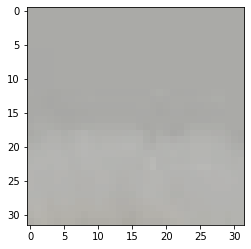

118


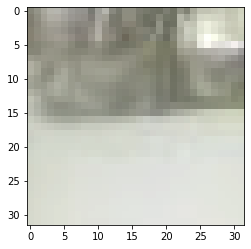

119


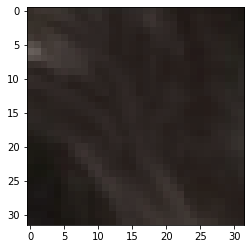

120


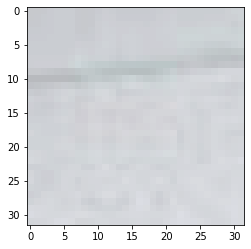

121


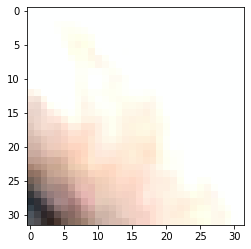

122


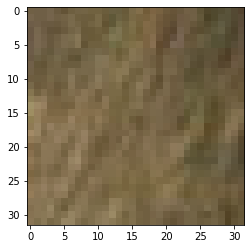

123


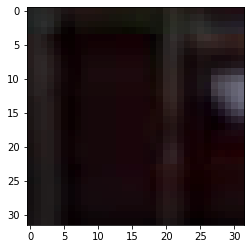

124


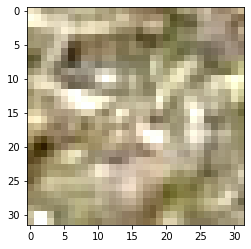

125


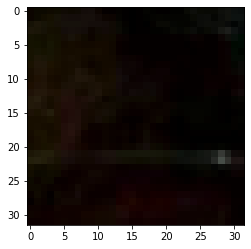

126


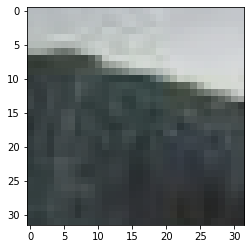

127


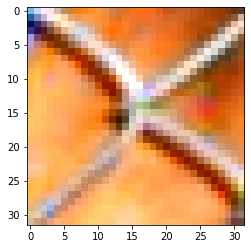

128


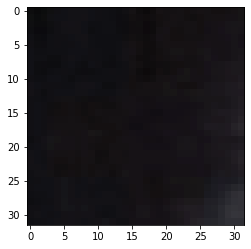

129


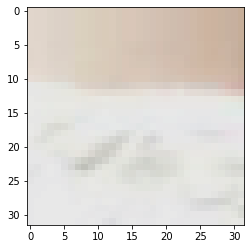

130


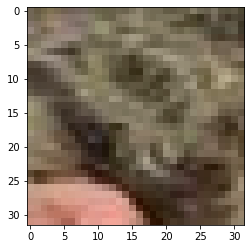

131


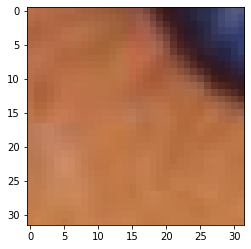

132


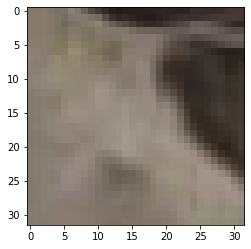

133


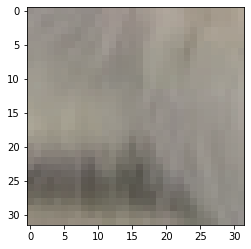

134


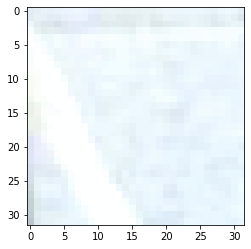

135


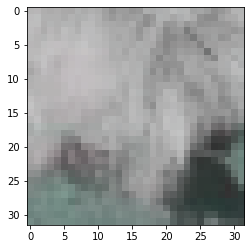

136


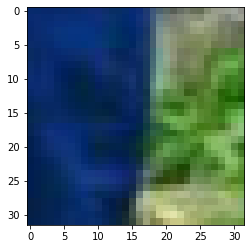

137


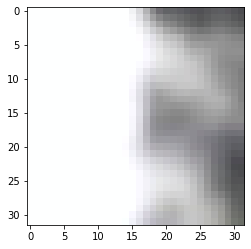

138


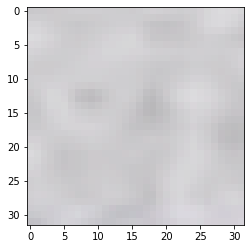

139


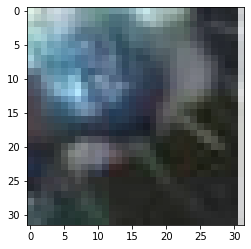

140


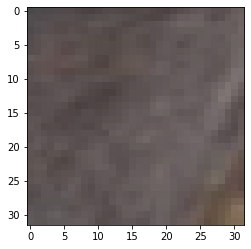

141


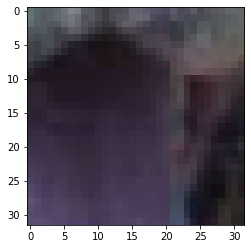

142


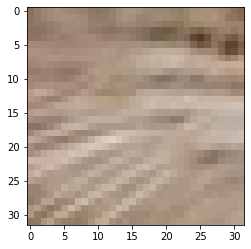

143


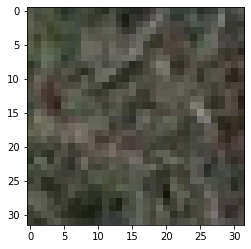

144


IndexError: index 144 is out of bounds for dimension 0 with size 144

In [29]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)
# print([class_names[x] for x in classes])
for i in range(100,150):
    print(i)
    imshow(inputs[i])

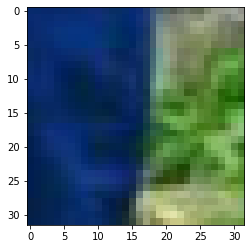

In [30]:
i_exp =136
imshow(inputs[i_exp])

In [31]:
vae.eval()
with torch.no_grad():
    x_ = inputs[i_exp].view(1, 3, _image_size, _image_size).to(device)
    print(x_.size())
    y, _, _= vae(x_)
    print(y.size())
    y = y.view(3, _image_size, _image_size)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


torch.Size([1, 3, 32, 32])


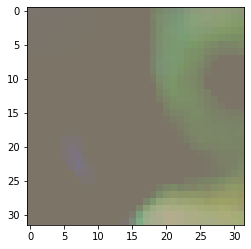

In [32]:
x_ = inputs[i_exp].view(1, 3, 32, _image_size).to(device)
y, _, _= vae(x_)
print(y.size())
y = y.view(3, _image_size, _image_size)
imshow(y.data.cpu())

In [515]:
def sample_radius(x_exp, r=None, n_samples=1000, random_state=None):
    print(x_exp.size)
    if isinstance(x_exp, np.ndarray):
        x_exp_tensor = torch.from_numpy(x_exp).to(device)
    else:
        x_exp_tensor = x_exp   
    x_enconde = vae.encode(x_exp_tensor)
#     print(x_enconde.size())
    x_enconde = torch.flatten(x_enconde, start_dim=1)
    mu_p, log_var_p = vae.fc_mu(x_enconde), vae.fc_log_var(x_enconde)
    ones = torch.ones(n_samples).to(device)
    print(mu_p.size())
    
    mu_m = torch.ger(ones, mu_p.view(-1))
    # TODO: TB: I am not sure if is better or not multiply the distance r by std_r.
    # TODO: TB: preliminary tests indicate that is better to not use std_r.
    std_r = torch.exp(0.5 * log_var_p).to(device)
    noise = torch.rand(n_samples, vae.latent_dim).to(device)*r*std_r 
    mu_m = mu_m + noise
    z = model.reparameterize(mu_m, log_var_p)
    
    z = vae.fc_out(z)
    z = z.view(-1, 512, 1, 1)
    
    x_p = vae.decode(z)
#     x_sample = x_p.reshape(-1, 3, 64, 64).cpu().detach().numpy()
    x_sample = x_p.reshape(-1, 3, _image_size, _image_size)
    # Clean cache torch.
    # TODO: TB: what is the best practice?
    del x_p
    del noise
    del mu_m
    torch.cuda.empty_cache()

    return x_sample

In [516]:
x_ = x_.cpu().detach().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [517]:
x_sample = sample_radius(x_, vae, r=0.01, n_samples=20)
print(x_sample.size())

TypeError: sample_radius() got multiple values for argument 'r'

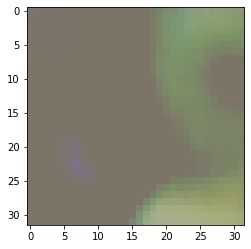

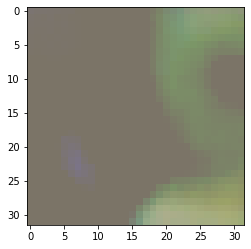

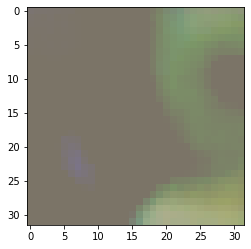

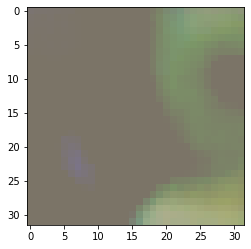

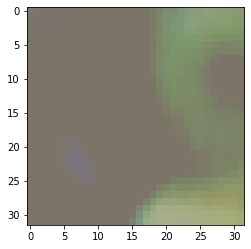

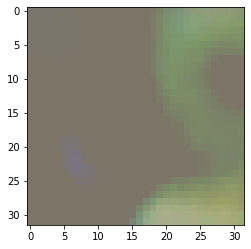

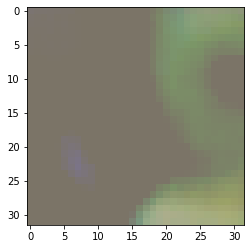

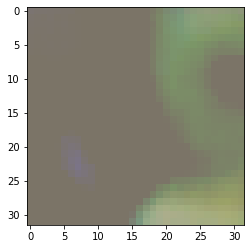

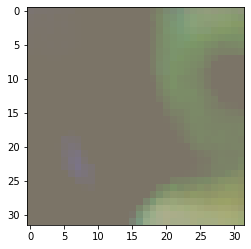

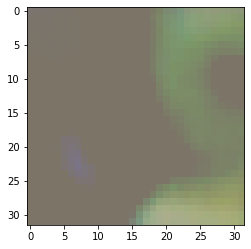

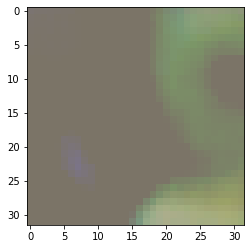

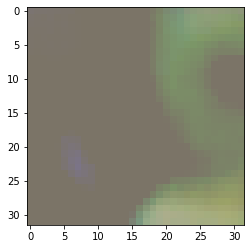

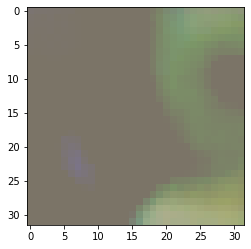

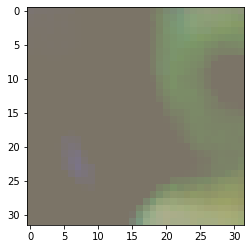

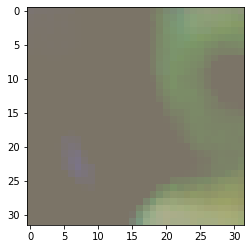

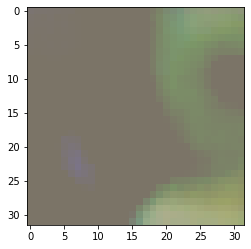

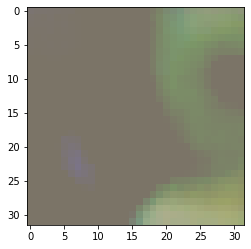

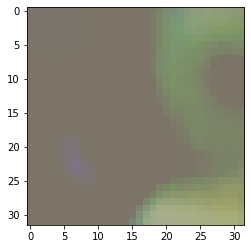

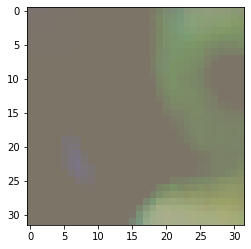

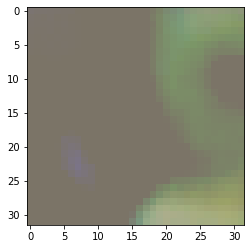

In [518]:
for i in range(20):
    imshow(x_sample[i].cpu().detach())

# TESTe

In [37]:
# Data augmentation and normalization for training
# Just normalization for validation
_image_size_big = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]

data_transforms_big = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(_image_size_big),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(.3, .3, .3),
        transforms.ToTensor(),
        transforms.Normalize(_mean, _std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(_image_size_big),
        transforms.ToTensor(),
        transforms.Normalize(_mean, _std)
    ]),
}

In [162]:
batch_size = 144
data_dir = '{:}/dogscats'.format(folder_data)

image_datasets_big = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_big[x])
                  for x in ['train', 'val']}

dataloaders_big = {x: torch.utils.data.DataLoader(image_datasets_big[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes_big = {x: len(image_datasets_big[x]) for x in ['train', 'val']}
class_names = image_datasets_big['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


data_loader_big = dataloaders_big['val']
data_loader_big.to(dvice)

In [163]:
test_big, _ = next(iter(data_loader_big))

In [164]:
data_transforms_big_train =  transforms.Compose([
         transforms.Resize(256),
        transforms.CenterCrop(_image_size),
         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(.3, .3, .3)

    ])

# Load resnet18

In [509]:
test_big = test_big.to(device)

In [510]:
model = None

In [701]:
from torchvision import models
import requests
if model is None:
    model = models.resnet18(pretrained=True)
    url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/' \
          'raw/596b27d23537e5a1b5751d2b0481ef172f58b539/imagenet1000_clsid_to_human.txt'
    imagenet_classes = eval(requests.get(url).content)
    model.eval()
def predict_class(x_):
    with torch.no_grad():
        y_pred = model(x_.view(-1, 3, 224, 224))
        preds = torch.nn.functional.softmax(y_pred[0], dim=0).data.cpu().numpy()
    return preds

def get_class(preds):
    res = np.argsort(preds)[::-1]
    return {imagenet_classes[e]:preds[e] for e in res[:10]}

model = model.to(device)

In [498]:
for e, ee in imagenet_classes.items():
    print(e, ee)
    if 'Cardigan, Cardigan Welsh corgi' == ee:
        break

0 tench, Tinca tinca
1 goldfish, Carassius auratus
2 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
3 tiger shark, Galeocerdo cuvieri
4 hammerhead, hammerhead shark
5 electric ray, crampfish, numbfish, torpedo
6 stingray
7 cock
8 hen
9 ostrich, Struthio camelus
10 brambling, Fringilla montifringilla
11 goldfinch, Carduelis carduelis
12 house finch, linnet, Carpodacus mexicanus
13 junco, snowbird
14 indigo bunting, indigo finch, indigo bird, Passerina cyanea
15 robin, American robin, Turdus migratorius
16 bulbul
17 jay
18 magpie
19 chickadee
20 water ouzel, dipper
21 kite
22 bald eagle, American eagle, Haliaeetus leucocephalus
23 vulture
24 great grey owl, great gray owl, Strix nebulosa
25 European fire salamander, Salamandra salamandra
26 common newt, Triturus vulgaris
27 eft
28 spotted salamander, Ambystoma maculatum
29 axolotl, mud puppy, Ambystoma mexicanum
30 bullfrog, Rana catesbeiana
31 tree frog, tree-frog
32 tailed frog, bell toad, ribbed to

## Create Patch

0
{'tub, vat': 0.19473875, 'toilet seat': 0.11475023, 'bathtub, bathing tub, bath, tub': 0.10707694, 'paper towel': 0.09303707, 'tabby, tabby cat': 0.066637486, 'washer, automatic washer, washing machine': 0.056013074, 'Persian cat': 0.048852723, 'washbasin, handbasin, washbowl, lavabo, wash-hand basin': 0.04682907, 'hamper': 0.046707086, 'toilet tissue, toilet paper, bathroom tissue': 0.03167178}


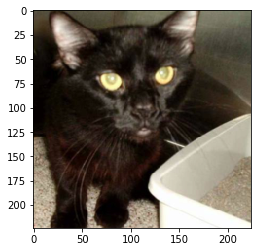

1
{'Egyptian cat': 0.48002887, 'tiger cat': 0.3107189, 'tabby, tabby cat': 0.07725692, 'lynx, catamount': 0.01792084, 'Ibizan hound, Ibizan Podenco': 0.014889011, 'red fox, Vulpes vulpes': 0.009737271, 'Siamese cat, Siamese': 0.0079252925, 'plastic bag': 0.006888947, 'window screen': 0.003954306, 'kit fox, Vulpes macrotis': 0.0036748967}


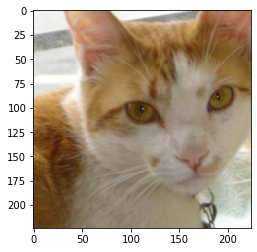

2
{'Siamese cat, Siamese': 0.59621763, 'Persian cat': 0.19410774, 'feather boa, boa': 0.041633077, 'remote control, remote': 0.017836815, 'cellular telephone, cellular phone, cellphone, cell, mobile phone': 0.013344195, 'carton': 0.013138026, 'Egyptian cat': 0.012302075, 'dishwasher, dish washer, dishwashing machine': 0.0102422545, 'tabby, tabby cat': 0.006669963, 'laptop, laptop computer': 0.0055073504}


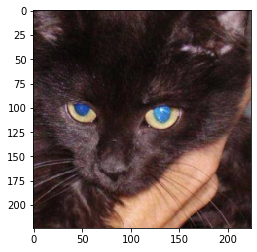

3
{'Maltese dog, Maltese terrier, Maltese': 0.78916746, 'Sealyham terrier, Sealyham': 0.070893586, 'Tibetan terrier, chrysanthemum dog': 0.051894315, 'Lhasa, Lhasa apso': 0.035384696, 'Old English sheepdog, bobtail': 0.021672644, 'West Highland white terrier': 0.010716118, 'Dandie Dinmont, Dandie Dinmont terrier': 0.010239247, 'Shih-Tzu': 0.006706058, 'soft-coated wheaten terrier': 0.00079245446, 'miniature schnauzer': 0.00067267375}


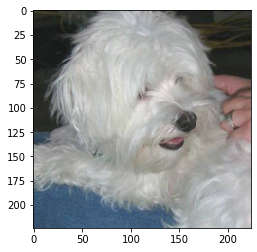

4
{'Egyptian cat': 0.43028906, 'lynx, catamount': 0.34558246, 'tabby, tabby cat': 0.07933598, 'Siamese cat, Siamese': 0.07205768, 'tiger cat': 0.031075617, 'bow tie, bow-tie, bowtie': 0.0026570691, 'computer keyboard, keypad': 0.0024695015, 'Persian cat': 0.002402626, 'space heater': 0.0021858714, 'laptop, laptop computer': 0.0020592853}


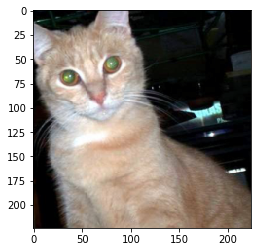

5
{'Persian cat': 0.16794753, 'tiger cat': 0.13477252, 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor': 0.1319362, 'tabby, tabby cat': 0.12814076, 'Egyptian cat': 0.068072185, 'lynx, catamount': 0.06775286, 'Siamese cat, Siamese': 0.0488685, 'lion, king of beasts, Panthera leo': 0.01833568, 'bucket, pail': 0.016224917, 'spider monkey, Ateles geoffroyi': 0.014783892}


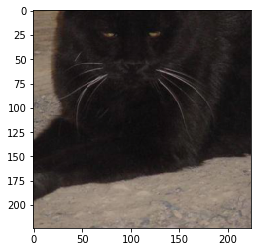

6
{'wild boar, boar, Sus scrofa': 0.24512571, 'beaver': 0.17451762, 'wombat': 0.16774265, 'hog, pig, grunter, squealer, Sus scrofa': 0.11068255, 'guinea pig, Cavia cobaya': 0.029734017, 'mink': 0.027458683, 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus': 0.025834657, 'mousetrap': 0.017017564, 'tabby, tabby cat': 0.016611379, 'otter': 0.013591658}


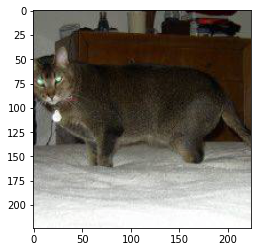

7
{'German shepherd, German shepherd dog, German police dog, alsatian': 0.7471349, 'kelpie': 0.08210795, 'toy terrier': 0.042757194, 'bluetick': 0.030952109, 'Australian terrier': 0.014565228, 'malinois': 0.012653765, 'muzzle': 0.007902749, 'miniature pinscher': 0.0071051284, 'Walker hound, Walker foxhound': 0.0056096576, 'Border terrier': 0.0054265717}


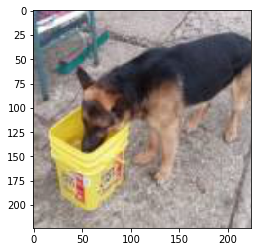

8
{'Norwegian elkhound, elkhound': 0.61951405, 'malinois': 0.15967788, 'German shepherd, German shepherd dog, German police dog, alsatian': 0.12827113, 'Leonberg': 0.010075743, 'dingo, warrigal, warragal, Canis dingo': 0.007286774, 'kelpie': 0.006005269, 'dhole, Cuon alpinus': 0.0039901924, 'red wolf, maned wolf, Canis rufus, Canis niger': 0.0037685614, 'Tibetan mastiff': 0.0034210414, 'muzzle': 0.0030893846}


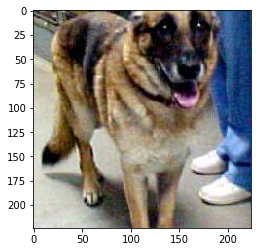

9
{'dingo, warrigal, warragal, Canis dingo': 0.55813986, 'Eskimo dog, husky': 0.1653396, 'Siberian husky': 0.0962878, 'Pembroke, Pembroke Welsh corgi': 0.025806796, 'coyote, prairie wolf, brush wolf, Canis latrans': 0.020951206, 'malinois': 0.019691505, 'kelpie': 0.019302055, 'German shepherd, German shepherd dog, German police dog, alsatian': 0.015983678, 'Cardigan, Cardigan Welsh corgi': 0.014585861, 'white wolf, Arctic wolf, Canis lupus tundrarum': 0.0145696085}


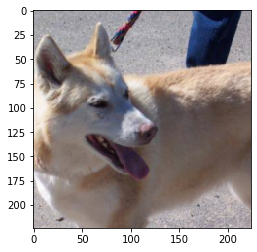

10
{'Walker hound, Walker foxhound': 0.19437283, 'black-and-tan coonhound': 0.16773972, 'Doberman, Doberman pinscher': 0.11943587, 'bluetick': 0.085177496, 'Saluki, gazelle hound': 0.06934464, 'EntleBucher': 0.06438051, 'toy terrier': 0.05953083, 'English foxhound': 0.038556226, 'basenji': 0.037790366, 'Appenzeller': 0.037427254}


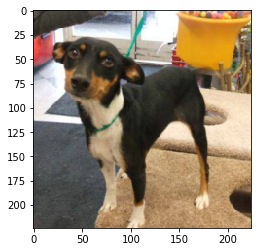

11
{'tabby, tabby cat': 0.3085153, 'Egyptian cat': 0.24407664, 'tiger cat': 0.098933145, 'space heater': 0.023947598, 'Angora, Angora rabbit': 0.022295564, 'wood rabbit, cottontail, cottontail rabbit': 0.01645476, 'laptop, laptop computer': 0.016286982, 'dishwasher, dish washer, dishwashing machine': 0.012832054, 'hamper': 0.012529384, 'mousetrap': 0.011920232}


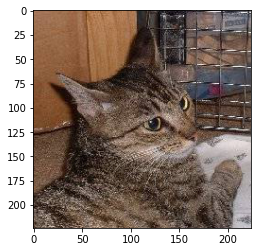

12
{'basset, basset hound': 0.64259946, 'beagle': 0.1817496, 'Walker hound, Walker foxhound': 0.1042574, 'English foxhound': 0.04506949, 'redbone': 0.011419904, 'bloodhound, sleuthhound': 0.008139673, 'bluetick': 0.004840946, 'Welsh springer spaniel': 0.00053942495, 'black-and-tan coonhound': 0.00036590215, 'German short-haired pointer': 0.00034024028}


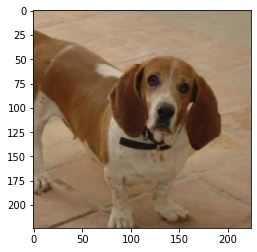

13
{'Japanese spaniel': 0.11224676, 'toy terrier': 0.105659224, 'Border collie': 0.099428326, 'Chihuahua': 0.057086922, 'skunk, polecat, wood pussy': 0.033425804, 'Siberian husky': 0.03321224, 'papillon': 0.02924699, 'Boston bull, Boston terrier': 0.022800498, 'upright, upright piano': 0.01814094, 'borzoi, Russian wolfhound': 0.01749418}


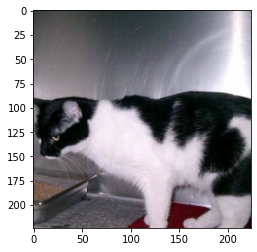

14
{'Egyptian cat': 0.38664037, 'tabby, tabby cat': 0.26457712, 'tiger cat': 0.14061545, 'Persian cat': 0.047918893, 'lynx, catamount': 0.04303992, 'remote control, remote': 0.014946013, 'carton': 0.011014205, 'mouse, computer mouse': 0.0070454925, 'Siamese cat, Siamese': 0.00619967, 'computer keyboard, keypad': 0.0044594137}


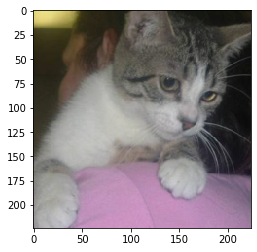

15
{'tabby, tabby cat': 0.42281368, 'tiger cat': 0.39794892, 'Egyptian cat': 0.14550418, 'lynx, catamount': 0.010649786, 'tiger, Panthera tigris': 0.004646211, 'Persian cat': 0.0046184016, 'mouse, computer mouse': 0.0021305596, 'space heater': 0.0008292022, 'dishwasher, dish washer, dishwashing machine': 0.00069730624, 'remote control, remote': 0.00053844537}


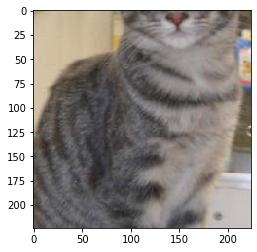

16
{'German short-haired pointer': 0.8464111, 'Labrador retriever': 0.064386986, 'Chesapeake Bay retriever': 0.03501875, 'curly-coated retriever': 0.03349968, 'flat-coated retriever': 0.010118561, 'kelpie': 0.0060731485, 'Great Dane': 0.0007432008, 'Staffordshire bullterrier, Staffordshire bull terrier': 0.00058752904, 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier': 0.0005357646, 'Doberman, Doberman pinscher': 0.0005121598}


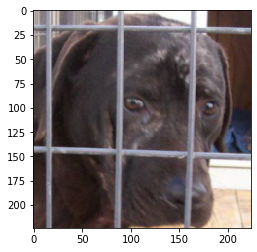

17
{'borzoi, Russian wolfhound': 0.23637185, 'English setter': 0.118809454, 'Cardigan, Cardigan Welsh corgi': 0.089203544, 'Walker hound, Walker foxhound': 0.08550181, 'bluetick': 0.06354161, 'basset, basset hound': 0.055400737, 'Border collie': 0.039846536, 'Brittany spaniel': 0.032422356, 'English foxhound': 0.0310358, 'sloth bear, Melursus ursinus, Ursus ursinus': 0.026460815}


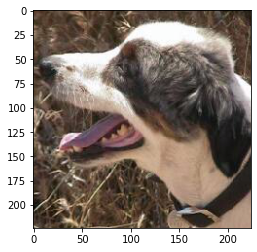

18
{'Chihuahua': 0.926269, 'toy terrier': 0.05032813, 'papillon': 0.009215506, 'kelpie': 0.0028881712, 'Pomeranian': 0.0025071385, 'miniature pinscher': 0.0019921511, 'Brabancon griffon': 0.001905269, 'Japanese spaniel': 0.00080814, 'Yorkshire terrier': 0.00047363245, 'Pekinese, Pekingese, Peke': 0.00040135492}


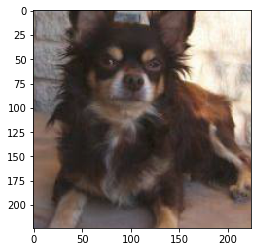

19
{'tabby, tabby cat': 0.17299518, 'Siamese cat, Siamese': 0.11531147, 'Egyptian cat': 0.10535674, 'Persian cat': 0.061443698, 'paper towel': 0.05480406, 'ping-pong ball': 0.04355652, 'tiger cat': 0.02962911, 'carton': 0.028764991, 'lynx, catamount': 0.022045486, 'mink': 0.020539893}


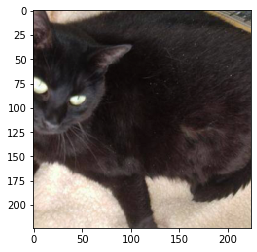

20
{'malinois': 0.5127161, 'muzzle': 0.1439672, 'Brabancon griffon': 0.05645272, 'Chesapeake Bay retriever': 0.040639818, 'Chihuahua': 0.034760844, 'Irish terrier': 0.025698101, 'Border terrier': 0.022661652, 'kelpie': 0.02116539, 'German shepherd, German shepherd dog, German police dog, alsatian': 0.017343886, 'bull mastiff': 0.016930472}


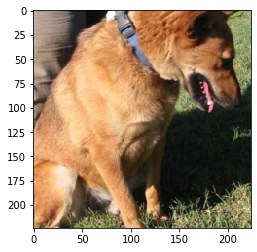

21
{'Labrador retriever': 0.6283422, 'golden retriever': 0.07252726, 'dingo, warrigal, warragal, Canis dingo': 0.046607334, 'bloodhound, sleuthhound': 0.03848644, 'kelpie': 0.03327438, 'redbone': 0.02404943, 'Walker hound, Walker foxhound': 0.023537152, 'English foxhound': 0.016967636, 'Rhodesian ridgeback': 0.01173149, 'Chesapeake Bay retriever': 0.010795512}


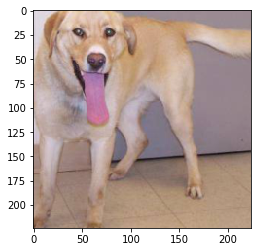

22
{'German shepherd, German shepherd dog, German police dog, alsatian': 0.9974004, 'bloodhound, sleuthhound': 0.0014172328, 'Norwegian elkhound, elkhound': 0.0005291919, 'beagle': 0.00012295406, 'malinois': 9.792718e-05, 'English foxhound': 7.1567134e-05, 'Walker hound, Walker foxhound': 6.473937e-05, 'timber wolf, grey wolf, gray wolf, Canis lupus': 3.5162084e-05, 'bluetick': 3.3472636e-05, 'kelpie': 2.4810637e-05}


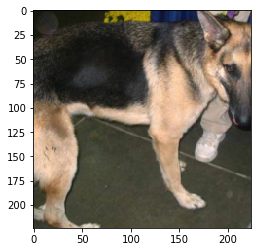

23
{'Egyptian cat': 0.41619942, 'marmoset': 0.2902707, 'African grey, African gray, Psittacus erithacus': 0.09072283, 'tabby, tabby cat': 0.03899206, 'guenon, guenon monkey': 0.0217185, 'lynx, catamount': 0.017032648, 'titi, titi monkey': 0.01632082, 'Persian cat': 0.011680339, 'tiger cat': 0.011314756, 'hamster': 0.008163357}


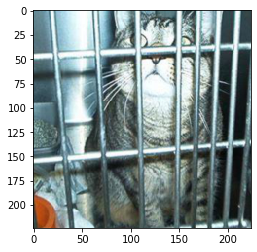

24
{'tabby, tabby cat': 0.6675502, 'Egyptian cat': 0.27176213, 'tiger cat': 0.05837284, 'lynx, catamount': 0.0013795989, 'Persian cat': 0.0004616606, 'space heater': 6.517083e-05, 'plastic bag': 5.5148805e-05, 'Siamese cat, Siamese': 4.9446902e-05, 'dishwasher, dish washer, dishwashing machine': 3.635549e-05, 'carton': 2.9744391e-05}


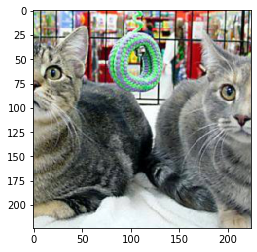

25
{'Samoyed, Samoyede': 0.422985, 'Great Pyrenees': 0.37247643, 'chow, chow chow': 0.040535152, 'Pomeranian': 0.030986892, 'malamute, malemute, Alaskan malamute': 0.019407328, 'keeshond': 0.018667227, 'Eskimo dog, husky': 0.011767244, 'white wolf, Arctic wolf, Canis lupus tundrarum': 0.009941935, 'collie': 0.007263533, 'kuvasz': 0.0063269436}


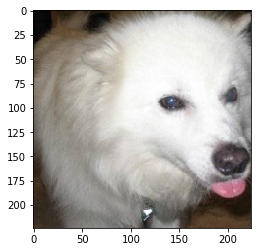

26
{'English springer, English springer spaniel': 0.54906154, 'German short-haired pointer': 0.27339202, 'bluetick': 0.059688084, 'Boston bull, Boston terrier': 0.035829812, 'Staffordshire bullterrier, Staffordshire bull terrier': 0.013794337, 'Great Dane': 0.010390649, 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier': 0.008952885, 'Walker hound, Walker foxhound': 0.0068937265, 'French bulldog': 0.006207363, 'basset, basset hound': 0.0050864317}


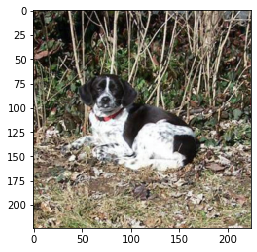

27
{'lynx, catamount': 0.27654818, 'Persian cat': 0.19726966, 'tiger cat': 0.14245477, 'Egyptian cat': 0.09107814, 'tabby, tabby cat': 0.072836116, 'Siamese cat, Siamese': 0.057837218, 'Angora, Angora rabbit': 0.03611248, 'marmoset': 0.02066228, 'fur coat': 0.019771991, 'hamster': 0.007001541}


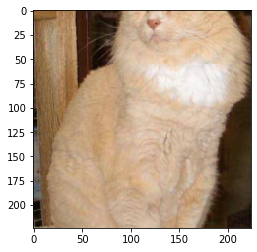

28
{'Egyptian cat': 0.45888978, 'tabby, tabby cat': 0.23051906, 'tiger cat': 0.035465255, 'Siamese cat, Siamese': 0.022709142, 'paper towel': 0.0151752755, 'dishwasher, dish washer, dishwashing machine': 0.0102905845, 'Siberian husky': 0.006017579, 'quilt, comforter, comfort, puff': 0.0055044508, 'Eskimo dog, husky': 0.005177106, 'Chihuahua': 0.0049530254}


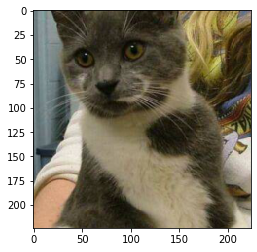

29
{'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier': 0.3676831, 'bull mastiff': 0.109363586, 'barbell': 0.09778993, 'Chesapeake Bay retriever': 0.08467137, 'Staffordshire bullterrier, Staffordshire bull terrier': 0.084258065, 'dumbbell': 0.048024412, 'Weimaraner': 0.03082974, 'Labrador retriever': 0.014100448, 'space heater': 0.013561768, 'French bulldog': 0.012802657}


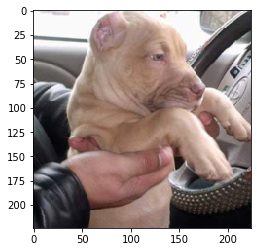

30
{'tabby, tabby cat': 0.5008495, 'Egyptian cat': 0.4328906, 'tiger cat': 0.062137786, 'wombat': 0.00067479844, 'lynx, catamount': 0.0004634227, 'Persian cat': 0.00030055805, 'sleeping bag': 0.00023592009, 'space heater': 0.00023223711, 'fox squirrel, eastern fox squirrel, Sciurus niger': 0.00012198896, 'plastic bag': 8.939264e-05}


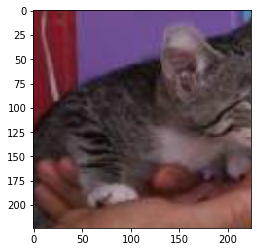

31
{'Persian cat': 0.1106492, 'skunk, polecat, wood pussy': 0.08486402, 'toy poodle': 0.06824959, 'weasel': 0.04083282, 'miniature poodle': 0.036994793, 'tabby, tabby cat': 0.035901353, 'mink': 0.035342377, 'black-footed ferret, ferret, Mustela nigripes': 0.028687082, 'jigsaw puzzle': 0.025442397, 'computer keyboard, keypad': 0.019447032}


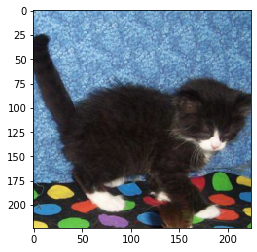

32
{'tabby, tabby cat': 0.8692175, 'tiger cat': 0.11338836, 'Egyptian cat': 0.01410111, 'quilt, comforter, comfort, puff': 0.0011592949, 'comic book': 0.00017920567, 'computer keyboard, keypad': 0.00013275197, 'mouse, computer mouse': 0.00011979412, 'laptop, laptop computer': 0.00011005315, 'space heater': 0.00010003839, 'plastic bag': 9.7156495e-05}


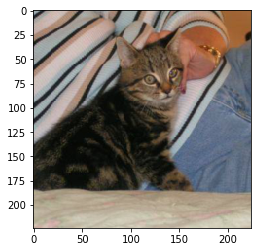

33
{'Cardigan, Cardigan Welsh corgi': 0.15710154, 'Egyptian cat': 0.1419914, 'toy terrier': 0.08152486, 'Pembroke, Pembroke Welsh corgi': 0.06728688, 'basenji': 0.06094725, 'doormat, welcome mat': 0.039329175, 'tabby, tabby cat': 0.03644416, 'space heater': 0.030635944, 'paper towel': 0.022342103, 'Boston bull, Boston terrier': 0.019962022}


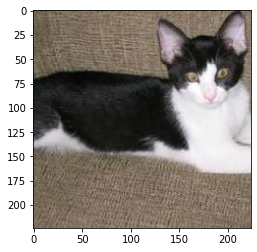

34
{'Siamese cat, Siamese': 0.7344552, 'Shih-Tzu': 0.035351463, 'Saint Bernard, St Bernard': 0.015094926, 'Siberian husky': 0.013648981, 'Pekinese, Pekingese, Peke': 0.012987873, 'Norwegian elkhound, elkhound': 0.010654789, 'paper towel': 0.007061391, 'German shepherd, German shepherd dog, German police dog, alsatian': 0.006261167, 'Chihuahua': 0.0062337155, 'tabby, tabby cat': 0.0055051683}


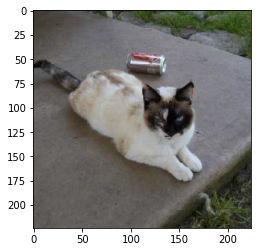

35
{'Siamese cat, Siamese': 0.9537553, 'Egyptian cat': 0.014250471, 'Angora, Angora rabbit': 0.0073411553, 'lynx, catamount': 0.0034604217, 'Persian cat': 0.0031934036, 'remote control, remote': 0.0015674465, 'affenpinscher, monkey pinscher, monkey dog': 0.0015224847, 'tabby, tabby cat': 0.00094335224, 'laptop, laptop computer': 0.0009009672, 'cellular telephone, cellular phone, cellphone, cell, mobile phone': 0.00081908493}


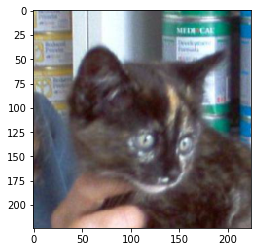

36
{'golden retriever': 0.4669468, 'Irish setter, red setter': 0.46337485, 'flat-coated retriever': 0.020223232, 'Irish terrier': 0.009812059, 'Sussex spaniel': 0.004672954, 'Tibetan mastiff': 0.0024660176, 'vizsla, Hungarian pointer': 0.0021784196, 'Brittany spaniel': 0.0020679438, 'collie': 0.0019408452, 'Newfoundland, Newfoundland dog': 0.0018208278}


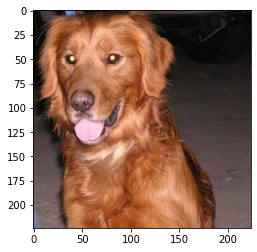

37
{'prison, prison house': 0.070778914, 'Persian cat': 0.06496525, 'window screen': 0.057912394, 'Pekinese, Pekingese, Peke': 0.05724673, 'window shade': 0.045966916, 'shoji': 0.04255802, 'Angora, Angora rabbit': 0.02993964, 'Tibetan mastiff': 0.025683632, 'Saint Bernard, St Bernard': 0.020039715, 'Leonberg': 0.01896963}


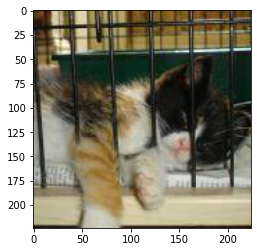

38
{'Egyptian cat': 0.1554749, 'Siamese cat, Siamese': 0.14198497, 'tabby, tabby cat': 0.0967276, 'radiator': 0.085604906, 'Chihuahua': 0.03898866, 'space heater': 0.03781333, 'doormat, welcome mat': 0.032732155, 'quilt, comforter, comfort, puff': 0.025179658, 'paper towel': 0.022395793, 'Persian cat': 0.018128557}


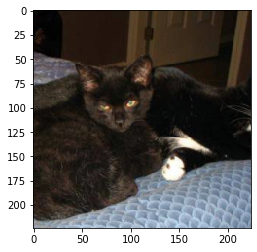

39
{'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier': 0.18115681, 'bull mastiff': 0.17255895, 'Labrador retriever': 0.15701306, 'Rhodesian ridgeback': 0.1226492, 'bloodhound, sleuthhound': 0.05543152, 'Border terrier': 0.042432055, 'golden retriever': 0.039103515, 'Chesapeake Bay retriever': 0.037808906, 'Staffordshire bullterrier, Staffordshire bull terrier': 0.030481828, 'malinois': 0.028548453}


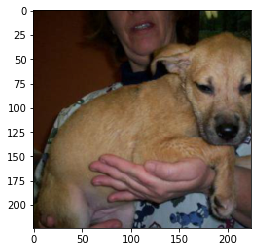

40
{'tiger cat': 0.10812483, 'Egyptian cat': 0.09858318, 'Persian cat': 0.09660277, 'lynx, catamount': 0.060330305, 'Angora, Angora rabbit': 0.058914717, 'hog, pig, grunter, squealer, Sus scrofa': 0.055486206, 'tabby, tabby cat': 0.037722055, 'Ibizan hound, Ibizan Podenco': 0.026493365, 'wallaby, brush kangaroo': 0.015416171, 'macaque': 0.014592253}


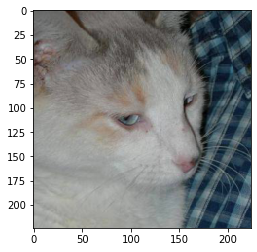

41
{'toy terrier': 0.45181617, 'wire-haired fox terrier': 0.106599495, 'Chihuahua': 0.08037003, 'bluetick': 0.079459, 'EntleBucher': 0.03014247, 'Bedlington terrier': 0.025739793, 'English foxhound': 0.02088103, 'Dandie Dinmont, Dandie Dinmont terrier': 0.015340704, 'Mexican hairless': 0.013656618, 'meerkat, mierkat': 0.012029153}


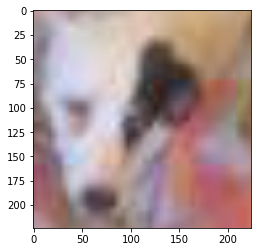

42
{'schipperke': 0.64403325, 'groenendael': 0.103459075, 'skunk, polecat, wood pussy': 0.05083775, 'Egyptian cat': 0.039021693, 'Scotch terrier, Scottish terrier, Scottie': 0.025528137, 'Siamese cat, Siamese': 0.010930016, 'giant schnauzer': 0.010525461, 'kelpie': 0.00807303, 'standard schnauzer': 0.0066615427, 'remote control, remote': 0.005536551}


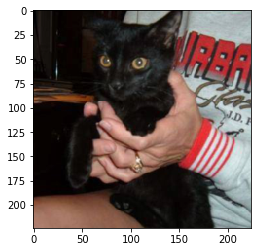

43
{'Siamese cat, Siamese': 0.63702166, 'Egyptian cat': 0.1346545, 'lynx, catamount': 0.06156777, 'tabby, tabby cat': 0.018597407, 'Chihuahua': 0.017902605, 'space heater': 0.011817326, 'tiger cat': 0.006985347, 'carton': 0.006303006, 'hamper': 0.004746705, 'red fox, Vulpes vulpes': 0.004696709}


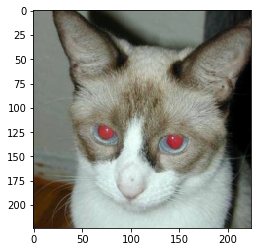

44
{'tabby, tabby cat': 0.7875749, 'Egyptian cat': 0.105013594, 'tiger cat': 0.08669477, 'quilt, comforter, comfort, puff': 0.005321182, 'hamper': 0.002131655, 'lynx, catamount': 0.0016938612, 'plastic bag': 0.0010990486, 'studio couch, day bed': 0.0010433611, 'washer, automatic washer, washing machine': 0.0007964577, 'window screen': 0.0007635388}


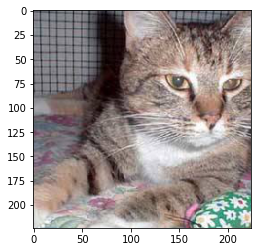

45
{'Egyptian cat': 0.40288246, 'tabby, tabby cat': 0.14505443, 'Siamese cat, Siamese': 0.04156473, 'tiger cat': 0.04075108, 'plastic bag': 0.01800225, 'carton': 0.01690763, 'feather boa, boa': 0.014288272, 'mouse, computer mouse': 0.013702123, 'sleeping bag': 0.013369119, 'bow tie, bow-tie, bowtie': 0.013062101}


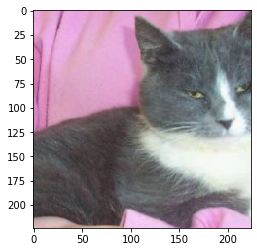

46
{'Siamese cat, Siamese': 0.59966385, 'lynx, catamount': 0.1584874, 'Egyptian cat': 0.10559922, 'tabby, tabby cat': 0.03510954, 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor': 0.022159174, 'Persian cat': 0.016156988, 'space heater': 0.013201766, 'tiger cat': 0.0062992526, 'window screen': 0.002394467, 'doormat, welcome mat': 0.0020028404}


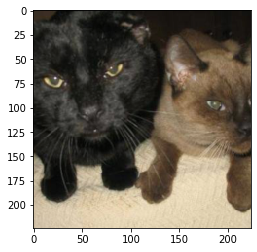

47
{'redbone': 0.29779023, 'Rhodesian ridgeback': 0.156698, 'golden retriever': 0.11990587, 'dingo, warrigal, warragal, Canis dingo': 0.09293891, 'Labrador retriever': 0.086345024, 'Chesapeake Bay retriever': 0.05721231, 'Irish terrier': 0.022938209, 'Border terrier': 0.01700236, 'bloodhound, sleuthhound': 0.015267322, 'bull mastiff': 0.013223418}


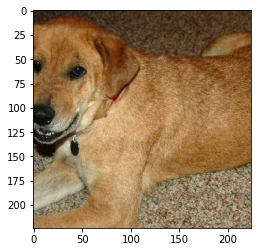

48
{'golden retriever': 0.87021154, 'Saluki, gazelle hound': 0.0315184, 'kuvasz': 0.030882938, 'Labrador retriever': 0.024248665, 'collie': 0.005388271, 'English setter': 0.005170604, 'Irish wolfhound': 0.0046574404, 'Brittany spaniel': 0.0043909815, 'Great Pyrenees': 0.0043460913, 'flat-coated retriever': 0.002014464}


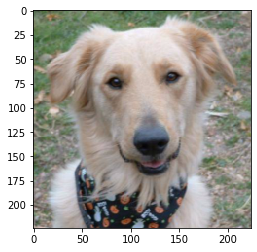

49
{'Labrador retriever': 0.37137908, 'dingo, warrigal, warragal, Canis dingo': 0.20534904, 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier': 0.09609768, 'Chesapeake Bay retriever': 0.06409005, 'Rhodesian ridgeback': 0.038398273, 'golden retriever': 0.038022976, 'kelpie': 0.03685225, 'bull mastiff': 0.021867497, 'Staffordshire bullterrier, Staffordshire bull terrier': 0.011248095, 'bloodhound, sleuthhound': 0.010647075}


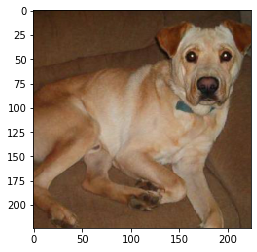

In [661]:
for i in range(0,50):
    x_explain = test_big[i].clone().detach()
    x_explain.size()
    print(i)
    print(get_class(predict_class(x_explain)))
    imshow(x_explain.cpu())

In [662]:
index = 33
x_explain = test_big[i].clone().detach()

In [663]:
_image_size = 32
y = torch.rand(3, _image_size, _image_size)
x_explain = test_big[index].clone()

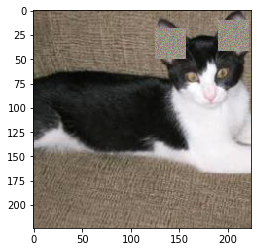

In [664]:
i, j, h, w = 18, 125, _image_size, _image_size
# i, j, h, w = 18, 90, _image_size, _image_size
# i, j, h, w = 30, 90, _image_size, _image_size
x_explain[:, i:i + h, j:j + w]
x_explain[:, i:i + h, j:j + w] = y
i2, j2, h, w = 10, 190, _image_size, _image_size
x_explain[:, i2:i2 + h, j2:j2 + w]
x_explain[:, i2:i2 + h, j2:j2 + w] = y

imshow(x_explain.detach())

In [605]:
# y, _, _= vae(x_explain_piace.view(1, 3, _image_size, _image_size).to(device))

In [606]:
# print(y.size())
# predict_patch(y[0])

In [607]:
# n_samples = 500
# try:
#     del x_sample1
# except:
#     pass
# torch.cuda.empty_cache()
# x_sample1 = sample_radius(x_explain_piace.view(-1, 3, _image_size, _image_size).cpu().detach().numpy(), vae, r=10, n_samples=n_samples)
# x_sample1.size()

In [608]:
# list_prop = []
# list_prop_cat = []
# for i_ in range(n_samples):
#     classes = predict_patch(x_sample1[i_])
# #     print(classes)
#     list_prop.append(classes['Cardigan, Cardigan Welsh corgi'])
#     list_prop_cat.append(classes['Egyptian cat'])
   
# #     print(classes)
# #     print(list_prop[-1])
# #     imshow(x_explain.detach())
    
# plt.hist(list_prop)
# plt.hist(list_prop_cat, label='cat')
# plt.legend()
# plt.show()



In [665]:
torch.cuda.empty_cache()

# Predict

In [695]:
def predict_patch(x_sample_):
    x_explain = test_big[index].clone()
    weight = 4
    num_samples = x_sample_.size()[0]
#     x_ = torch.zeros([num_samples, 3, _image_size_big, _image_size_big], dtype=torch.float32).to(device)
    x_explain = x_explain.repeat(num_samples,1,1).view(-1, image_channels, _image_size_big, _image_size_big).to(device)
    print('x_sample_', x_sample_.size())
    print('x_explain', x_explain.size())
    x_explain[:, :, i:i + h, j:j + w] += weight*x_sample_/(weight+1)
#     imshow(x_explain)
    return predict_class(x_explain)

In [696]:
x_explain.size()

torch.Size([3, 224, 224])

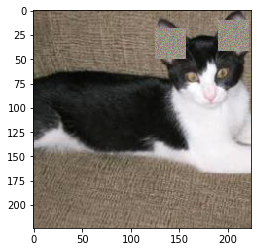

In [697]:
imshow(x_explain)

In [698]:

# from density_lime.explanations.linear import ExplainLinear

In [699]:
def sample_radius(x_exp, r=None, n_samples=1000, random_state=None):
    print(x_exp.size())
    if isinstance(x_exp, np.ndarray):
        x_exp_tensor = torch.from_numpy(x_exp).to(device)
    else:
        x_exp_tensor = x_exp   
    x_enconde = vae.encode(x_exp_tensor)
#     print(x_enconde.size())
    x_enconde = torch.flatten(x_enconde, start_dim=1)
    mu_p, log_var_p = vae.fc_mu(x_enconde), vae.fc_log_var(x_enconde)
    ones = torch.ones(n_samples).to(device)
    print(mu_p.size())
    
    mu_m = torch.ger(ones, mu_p.view(-1))
    # TODO: TB: I am not sure if is better or not multiply the distance r by std_r.
    # TODO: TB: preliminary tests indicate that is better to not use std_r.
    std_r = torch.exp(0.5 * log_var_p).to(device)
    noise = torch.rand(n_samples, vae.latent_dim).to(device)*r*std_r 
    mu_m = mu_m + noise
    z = vae.reparameterize(mu_m, log_var_p)
    
    z = vae.fc_out(z)
    z = z.view(-1, 512, 1, 1)
    
    x_p = vae.decode(z)
#     x_sample = x_p.reshape(-1, 3, 64, 64).cpu().detach().numpy()
    x_sample = x_p.reshape(-1, 3, _image_size, _image_size)
    # Clean cache torch.
    # TODO: TB: what is the best practice?
    del x_p
    del noise
    del mu_m
    torch.cuda.empty_cache()

    return x_sample

In [702]:
density = None
class_to_explain = 264
explain_linear = ExplainLinear(model_predict=predict_patch, density=density, linear_model='SGD', verbose=True)
result = explain_linear.explain_instance(
    x_explain=x_explain_piace.view(1, 3, 32, 32).to(device), r=0.1, class_index=class_to_explain, tol=0.1, n_samples=200)
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
fig, axis = plt.subplots(1, figsize=(4.5, 4.5))
ax = plot_instances(axis, x_explain, y)
a = ImagePlot.plot_importance(result['importance'], standardization=True)


torch.Size([1, 3, 32, 32])
torch.Size([1, 512])
x_sample_ torch.Size([200, 3, 32, 32])
x_explain torch.Size([200, 3, 224, 224])


IndexError: too many indices for array

In [597]:
z = torch.tensor([1,2,3])
z.repeat(1,4)#.view(-1, 3)

tensor([[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]])

In [594]:
import warnings
from collections import defaultdict
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.metrics.pairwise import euclidean_distances

standard_linear_models = {
    'SGD': SGDRegressor
}


class ExplainLinear(object):
    # TODO: The explanation can be generated in a progressive way,
    #  we could generate more and more instances to minimize some criteria,
    #  one example could be the error of the linear model or a search to find
    #  a prediction from the sample that are desired.

    def __init__(self, model_predict, density, linear_model='SGD', random_state=None, verbose=False):
        """
        Simple class to perform linear explanation from a model
        :param model_predict: model that the explanation want to be generated.
        :param density:  Density class, manifold estimation object that will be used to sample data.
        :param random_state: seed for random condition.
        :param linear_model: linear model that will be used to generate the explanation.
        See standard_linear_models variable.
        """
        self.density = density
        self.random_state = random_state
        if isinstance(linear_model, str):
            if linear_model in standard_linear_models:
                self.local_model = None
                self.local_model = standard_linear_models[linear_model]()
                self.model_linear = linear_model
            else:
                raise Exception(
                    'linear_model should be in the list {:}. '
                    'You can also use our on linear model by instantiate in the linear_model.')
        else:
            self.local_model = linear_model
            self.model_linear = 'custom'

        self.model_predict = model_predict

        self.predictions_index = set()
        self.predictions_stat = {
            'count': defaultdict(int)
            , 'mean_probability': defaultdict(float)
            , 'std_probability': defaultdict(float)
        }

    # def explain_instance(self, x_explain, r, class_index=0, n_samples=2000):
    #     x_samples = self.density.sample_radius(
    #         x_exp=x_explain
    #         , r=r
    #         , random_state=self.random_state
    #         , n_samples=n_samples
    #     )
    #     return self.fit_samples(x_samples, class_index)

    def explain_instance(self, x_explain, r, class_index=0, epochs=None, n_samples=2000, tol=0.1, epochs_max=100):
        """
        Generate a linear model to explain a instance locally
        :param x_explain: instance to be explained
        :param r: radius of the ball of the neighborhood
        :param class_index: class which an explanation will be created
        :param epochs: number of epochs to generate the linear model
        :param n_samples: number of samples for each epochs
        :param tol: tolerance of the change in the importance
        :param epochs_max: number max of epochs to achieve the tol
        :return: explanation in a dict with importance, see status
        """
        importance_0 = None
        diff = tol*10
        if epochs is None:
            epochs = epochs_max
        for epoch in range(epochs):
            x_samples = sample_radius(
                x_exp=x_explain
                , r=r
                , random_state=self.random_state
                , n_samples=n_samples
            )
            print(x_samples.size())
            print(y_p)
            y_p = self.model_predict(x_samples)
            self.stats_(y_p)
            self.local_model.partial_fit(x_samples, y_p[:, class_index])

            if importance_0 is None:
                importance_0 = self.local_model.coef_.copy()
            else:
                diff = np.sum(np.abs(importance_0 - self.local_model.coef_))
                if diff < tol:
                    self.results()
                importance_0 = self.local_model.coef_.copy()

        if diff > tol:
            warnings.warn(
                """Convergence tolerance (tol) was not achieved! 
                Current difference in the importance {:}.""".format(tol))
        return self.results()

    # def fit_samples(self, x_samples, class_index):
    #     result = dict()
    #     result['most_predicted'] = self.most_predicted(y_p)
    #     # Linear Model
    #     self.local_model.fit(x_samples, y_p[:, class_index])
    #     result['cof'] = self.local_model.coef_
    #     return result

    def fit_samples(self, x_samples, class_index):
        y_p = self.model_predict(x_samples)
        result = dict()
        result['most_predicted'] = self.most_predicted(y_p)
        # Linear Model
        self.local_model.fit(x_samples, y_p[:, class_index])
        result['cof'] = self.local_model.coef_
        return result

    def results(self):
        result = dict()
        result['stats'] = self.stats()
        # Linear Model
        result['importance'] = self.local_model.coef_
        return result

    def stats_(self, y_p):
        print(y_p.size())
        class_index = np.argsort(y_p[:, :], axis=1)
        unique, counts = np.unique(class_index[:, -3:], return_counts=True)
        self.predictions_index.update(unique)
        for key, value in zip(unique, counts):
            self.predictions_stat['count'][key] += value
            self.predictions_stat['mean_probability'][key] += np.mean(y_p[:, key])
            self.predictions_stat['std_probability'][key] += np.std(y_p[:, key])

    def stats(self):
        results = dict()
        for key in self.predictions_index:
            results[key] = {
                'count': self.predictions_stat['count'][key]
                , 'mean_probability': self.predictions_stat['mean_probability'][key]/self.predictions_stat['count'][key]
                , 'std_probability': self.predictions_stat['std_probability'][key]/self.predictions_stat['count'][key]
            }

        return results

    def find_contra_example(self, x_explain, r=0.1, n_samples=1000, target=None, class_target=None):
        """
        This routine should optimize a path from the source to a target instance
        defined by the prediction of the model.
        TODO: To implement this I will sample from instances from density  and find the
         best instance to the close target. With this new target, I will sample from it
         and optimize again. The optimization should be carried out up to convergence of the
         predicted target.
        :param x_explain:
        :param target:
        :return:
        """
        x_find = x_explain
        for epoch in range(epochs):
            x_samples = self.density.sample_radius(
                x_exp=x_find
                , r=r
                , random_state=self.random_state
                , n_samples=n_samples
            )
            y_p = self.model_predict(x_samples)
            class_index = np.argsort(y_p[:, :], axis=1)


        return self.results()